In [ ]:
import json
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from torch.utils.data import TensorDataset, DataLoader

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Loading & Pre-Processing Data

In [ ]:
lemmatizer = WordNetLemmatizer()
def normalize_elongated_words(text):
  words = text.split()
  normalized_words = [lemmatizer.lemmatize(word) for word in words]
  return ' '.join(normalized_words)

def clean_text(text):
  text = text.lower()
  text = re.sub(r'http\S+|www\S+', '', text)
  text = re.sub(r'\[.*?\]\(http\S+?\)', '', text)
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
  text = re.sub(r'(.)\1{2,}', r'\1\1', text)

  text = normalize_elongated_words(text)

  text = ' '.join([word for word in text.split() if word not in stopwords])

  return text.strip()

In [ ]:
data = []
with open('gold_train.jsonl', 'r', encoding='utf-8') as f:
  for line in f:
    entry = json.loads(line)
    data.append({
        'label' : entry['label'],
        'cleaned_context' : clean_text(entry['context']),
        'cleaned_target' : clean_text(entry['target'])
    })

df = pd.DataFrame(data)

val_data = []
with open('gold_val.jsonl', 'r', encoding='utf-8') as f:
  for line in f:
    entry = json.loads(line)
    val_data.append({
        'label' : entry['label'],
        'cleaned_context' : clean_text(entry['context']),
        'cleaned_target' : clean_text(entry['target'])
    })

val_df = pd.DataFrame(val_data)

test_data = []
with open('gold_test.jsonl', 'r', encoding='utf-8') as f:
  for line in f:
    entry = json.loads(line)
    test_data.append({
        'label' : entry['label'],
        'cleaned_context' : clean_text(entry['context']),
        'cleaned_target' : clean_text(entry['target'])
    })

test_df = pd.DataFrame(test_data)

In [ ]:
import torch
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

tokenized_data = tokenizer(
    df['cleaned_context'].tolist(),
    df['cleaned_target'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

input_ids = tokenized_data['input_ids']
attention_mask = tokenized_data['attention_mask']

print("\nExample Tokenized IDs:\n", input_ids[:2])
print("\nExample Attention Masks:\n", attention_mask[:2])

decoded_text = tokenizer.decode(input_ids[0], skip_special_tokens=False)
print("\nDecoded Text:\n", decoded_text)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


Example Tokenized IDs:
 tensor([[    0,  1350, 42647,  ...,     1,     1,     1],
        [    0,  8458,   225,  ...,     1,     1,     1]])

Example Attention Masks:
 tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

Decoded Text:
 <s>uk fucked</s></s>uk world fucked ftfy</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [ ]:
df['label'] = df['label'].astype(int)
labels = torch.tensor(df['label'].tolist())

In [ ]:
dataset = TensorDataset(input_ids, attention_mask, labels)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
import torch.nn as nn
from transformers import RobertaModel

class CustomRoBERTaClassifier(nn.Module):
    def __init__(self):
        super(CustomRoBERTaClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, 3)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state
        pooled_output = hidden_state[:, 0]
        dropped = self.dropout(pooled_output)
        logits = self.classifier(dropped)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {'loss' : loss, 'logits' : logits}
        return {'logits' : logits}

In [ ]:
model = CustomRoBERTaClassifier()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=1e-5)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.train()

for epoch in range(2):
  total_loss = 0
  for batch in dataloader:
    b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]

    optimizer.zero_grad()
    outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)

    loss = outputs['loss']
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader) :.4f}')

Epoch 1, Loss: 1.0754
Epoch 2, Loss: 1.0282


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch.nn.functional as F
import numpy as np

In [ ]:
def evaluate(model, dataloader):
  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in dataloader:
      b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]

      outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
      logits = outputs['logits']

      preds = torch.argmax(F.softmax(logits, dim=1), dim=1).cpu().numpy()
      labels = b_labels.cpu().numpy()

      all_preds.extend(preds)
      all_labels.extend(labels)

    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

    return acc, precision, recall, f1, all_preds

In [ ]:
torch.save(model.state_dict(), 'custom_roberta_classifier.pt')

In [ ]:
import time

def create_dataloader(df, tokenizer, max_length=512, batch_size=8):
    tokenized_data = tokenizer(
        df['cleaned_context'].tolist(),
        df['cleaned_target'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    input_ids = tokenized_data['input_ids']
    attention_mask = tokenized_data['attention_mask']
    # Ensure 'label' column is of numeric type before creating the tensor
    labels = torch.tensor(pd.to_numeric(df['label']).tolist())
    dataset = TensorDataset(input_ids, attention_mask, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    return dataloader

val_dataloader = create_dataloader(val_df, tokenizer)
test_dataloader = create_dataloader(test_df, tokenizer)

start_time = time.time()

val_acc, val_precision, val_recall, val_f1, val_preds = evaluate(model, val_dataloader)
print(f'Validation Accuracy: {val_acc:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')

test_acc, test_precision, test_recall, test_f1, test_preds = evaluate(model, test_dataloader)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

end_time = time.time()
computational_time = end_time - start_time
print(f'Computational Time: {computational_time:.4f} seconds')

Validation Accuracy: 0.5161
Validation Precision: 0.4242
Validation Recall: 0.4287
Validation F1 Score: 0.4156
Test Accuracy: 0.5442
Test Precision: 0.4918
Test Recall: 0.4516
Test F1 Score: 0.4277
Computational Time: 37.2342 seconds


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='coolwarm',
        xticklabels=labels,
        yticklabels=labels
    )

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
print(val_df['label'].unique())

['2' '1' '0']


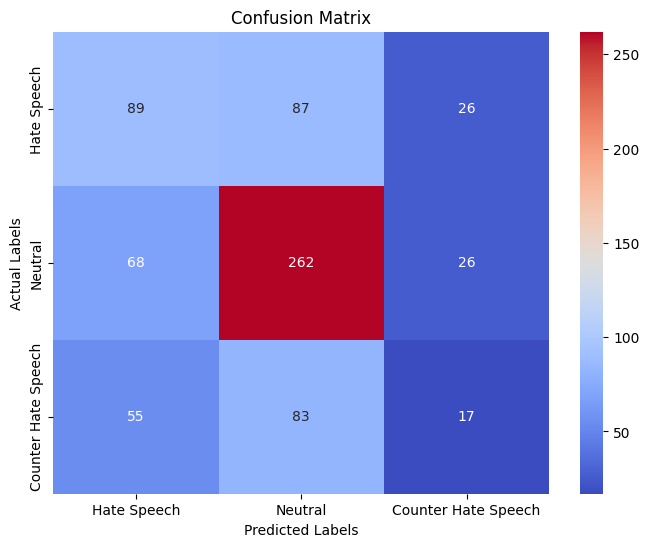

In [ ]:
val_true = [int(label) for label in val_df['label'].tolist()]
val_preds = [int(pred) for pred in val_preds]

plot_confusion_matrix(val_true, val_preds, ['Hate Speech', 'Neutral', 'Counter Hate Speech'])

**Note: Majority are predicted as Label 1, as they are the majority in the dataset (Class Imbalance)**